In [1]:
# для Colab
!pip install pmdarima

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import sys
sys.path.insert(0, '..')

from itertools import product
from tqdm.notebook import tqdm

from preprocessor import Preprocessor
from metrics import root_mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

%matplotlib inline
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Будем рассматривать два дата-сета: апериодический(информация о стоимости акций на американской бирже NASDAQ) и периодический(с ярко выраженной сезонностью и трендом) датасет с данными о ежемесячном производстве электричества.


In [3]:
# для Colab
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH_APERIODIC = '/content/drive/My Drive/HobbyTaste/data/nasdaq100_padding.csv'
DATA_PATH_PERIODIC = '/content/drive/My Drive/HobbyTaste/data/Electric_Production.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#DATA_PATH_APERIODIC = '../data/nasdaq100_padding.csv'
#DATA_PATH_PERIODIC = '../data/electric_production.csv'

In [0]:
nasdaq_df = pd.read_csv(DATA_PATH_APERIODIC)
electric_production_df = pd.read_csv(DATA_PATH_PERIODIC)
D_size = 3

Посмотрим на данные, используя класс Preprocessor

In [0]:
nasdaq_preproc_data = Preprocessor(data=nasdaq_df.iloc[:40000, :].values,
                                   D_size=3)
elec_prod_preproc = Preprocessor(
    data=electric_production_df.iloc[:, 1].values.reshape(-1, 1), D_size=1)

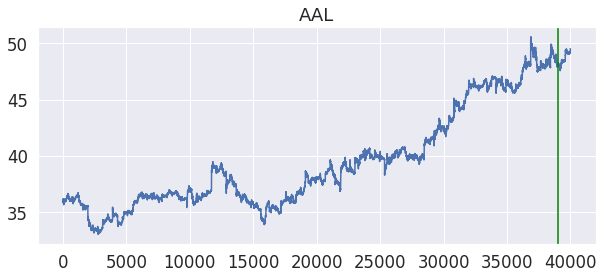

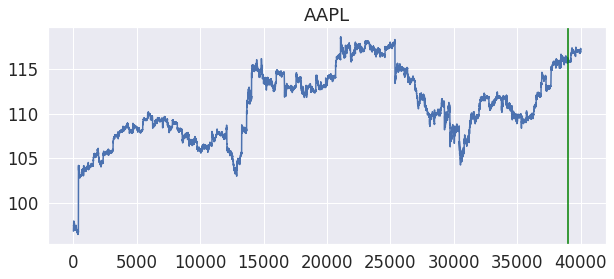

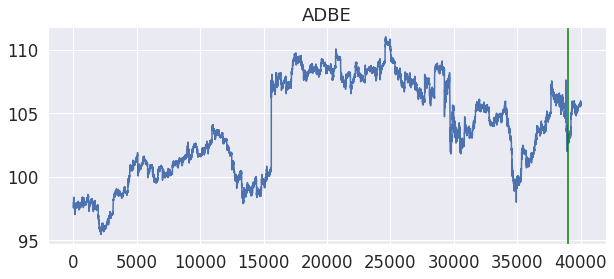

In [7]:
nasdaq_preproc_data.train_test_split(train_size=39000)
nasdaq_preproc_data.plot_data(titles=nasdaq_df.columns[:5])

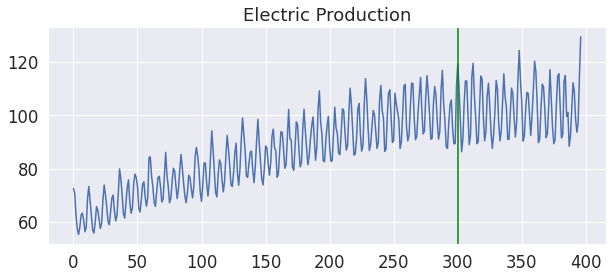

In [8]:
elec_prod_preproc.train_test_split(train_size=300)
elec_prod_preproc.plot_data(titles=['Electric Production'])

Воспользуемся моделью VAR(p). Это простая регрессия на последние p компонент временного ряда. Хорошие предсказания без предварительной обработки ряда вряд ли получится получить, т.к. модель совсем не учитывает особенности ряда. Именно поэтому ее можно хорошо применять, например, к стационарным рядам, тем не менее, попробуем VAR(p) на исходных данных.


In [0]:
model = VAR(nasdaq_preproc_data.train_data)

Посмотрим на разные значения p, выберем подходящее исходя из критериев информативности.

In [0]:
model_fit = model.fit(maxlags=50, ic='aic')

In [0]:
p = model_fit.k_ar

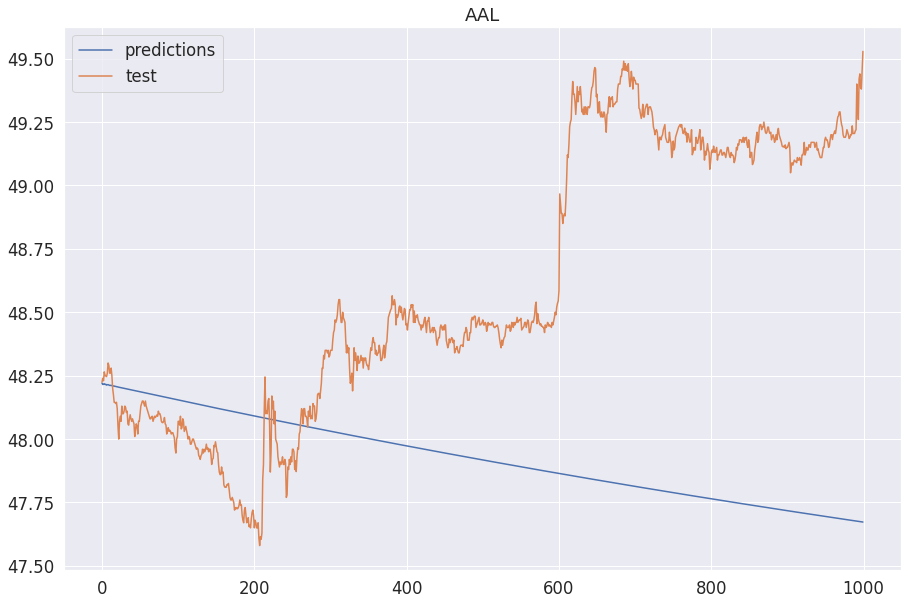

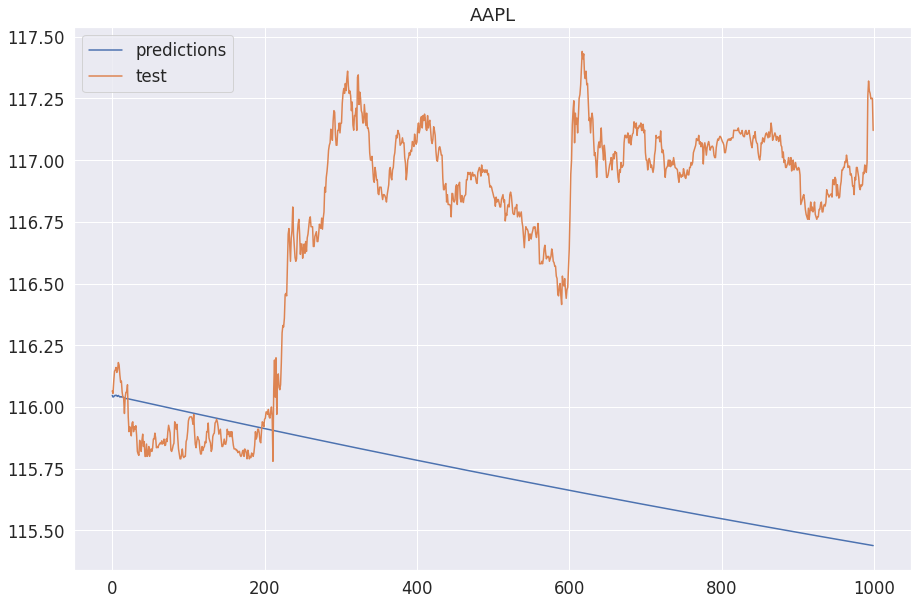

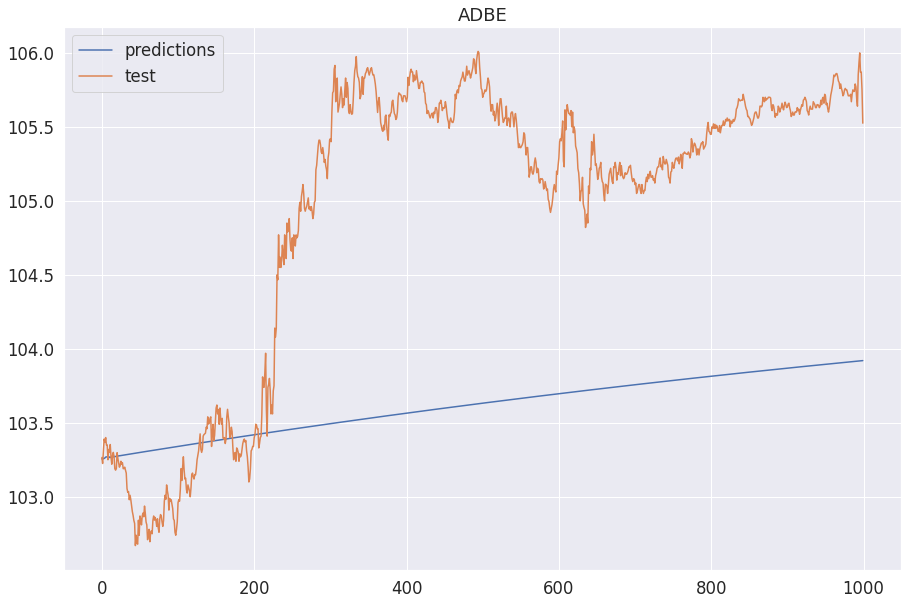

In [12]:
predictions = model_fit.forecast(nasdaq_preproc_data.train_data[-p:],
                                 steps=1000)
for i in np.arange(D_size):
    plt.figure(figsize=(15, 10))
    plt.title(nasdaq_df.columns[i])
    plt.plot(predictions[:, i], label='predictions')
    plt.plot(nasdaq_preproc_data.test_data[:, i], label='test')
    plt.legend()
    plt.show()

In [0]:
model = AR(elec_prod_preproc.train_data)

In [0]:
model_fit = model.fit(maxlags=30, ic='aic')

In [0]:
predictions = model_fit.predict(start=elec_prod_preproc.train_size,
                                end=elec_prod_preproc.train_size+\
                                elec_prod_preproc.test_size)

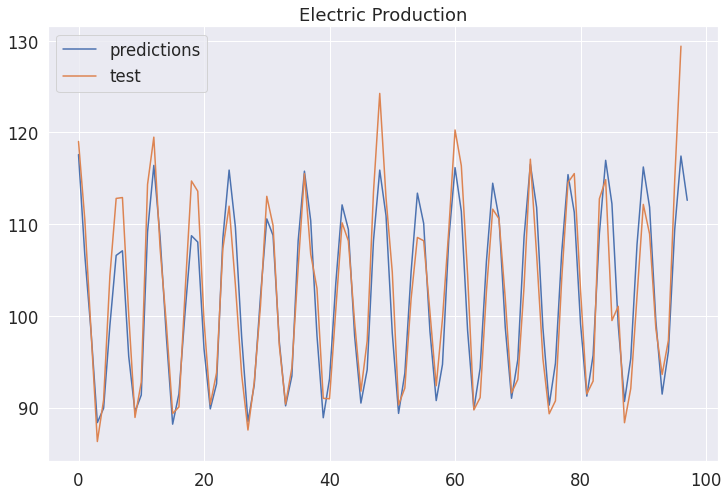

In [16]:
plt.figure(figsize=(12, 8))
plt.title('Electric Production')
plt.plot(predictions, label='predictions')
plt.plot(elec_prod_preproc.test_data, label='test')
plt.legend()
plt.show()

Как видим, т.к. я указал максимальное количество лагов=30, модель смогла найти ежемесячные закономерности и мы получили неплохой результат на тестовой выборке, что и видно на графике.

Однако без обработки данных и их исследования, модель VAR оказывается вообще говоря малоэффективной, для апериодического ряда, например, угадывается лишь некотрый тренд.



Посмотрим на модель SARIMAX(ARIMA с сезонностью). 


In [0]:
elec_prod_preproc.train_data = elec_prod_preproc.train_data.reshape(-1)

Подберем оптимальные параметры для модели SARIMAX, используя информационный критерий Акаике.

In [18]:
model = pm.auto_arima(elec_prod_preproc.train_data, 
                      start_p=1, 
                      start_q=1,
                      test='adf',
                      m=12,#данные ежемесячные
                      max_p=7,
                      max_q=7,
                      max_P=4,
                      max_Q=4,
                      seasonal=True,
                      error_action='ignore', 
                      trace=True)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=1285.126, BIC=1307.104, Time=1.872 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=1470.224, BIC=1477.550, Time=0.039 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=1335.653, BIC=1350.305, Time=0.665 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=1310.141, BIC=1324.793, Time=0.683 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=1531.381, BIC=1535.044, Time=0.033 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=1283.548, BIC=1301.863, Time=1.294 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=1376.662, BIC=1391.314, Time=0.290 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 2, 12) (constant=True); AIC=1284.820, BIC=1306.798, Time=3.300 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 0, 12) (constant=True); AIC=1337.555, BIC=1355.869, Time=1.146 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 2, 12) (constant=True); AIC=1284.833,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: (2, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=1285.670, BIC=1307.648, Time=2.752 seconds
Total fit time: 26.549 seconds


In [0]:
electric_production_predictions = model.predict(len(elec_prod_preproc.test_data))

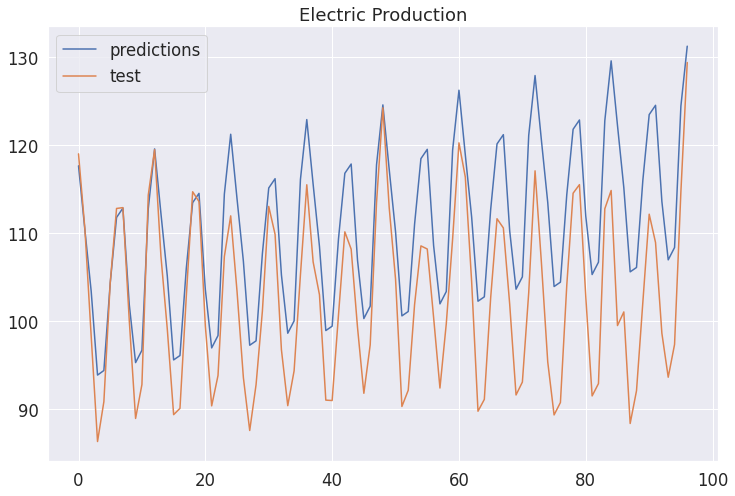

In [20]:
plt.figure(figsize=(12, 8))
plt.title('Electric Production')
plt.plot(electric_production_predictions, label='predictions')
plt.plot(elec_prod_preproc.test_data, label='test')
plt.legend()
plt.show()

Как видими, графики визуально похожи, однако на пика достигается значительная разница. Значение метрики из-за этого скорее всего будет достаточно высоким.

Попробуем ARIMA для апериодического датасета. Рассмотрим акции компании APPLE.

In [0]:
apple_data_train = nasdaq_preproc_data.train_data[:, 1]
apple_data_test = nasdaq_preproc_data.test_data[:, 1]
apple_data = nasdaq_preproc_data.data[:, 1]

In [0]:
diff_log_apple_train = np.diff(np.log(apple_data_train))

Воспользуемся тестом Дики-Фуллера, посмотрим на pvalue.

In [23]:
adfuller(diff_log_apple_train)[1]

0.0

Будем смотреть на логарифм исходных данных. Дальнейшее дифференцирование дает стационарный ряд(гипотеза о не стационарности отвергается). Аналогично, проведем поиск параметров, исходя из критерия информативности Акаике. Но сначала посмотрим на графики авторреляций.

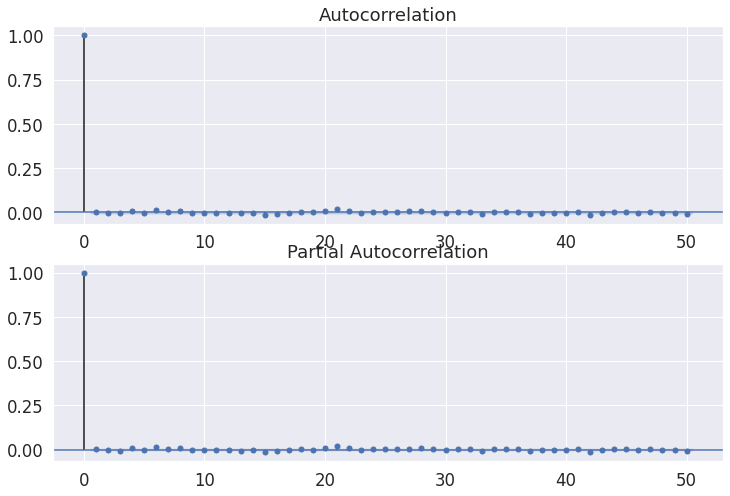

In [24]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff_log_apple_train, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff_log_apple_train, lags=50, ax=ax2)
plt.show()

Исходя из построенных графиков автокорреляций и частичных автокорреляций можно сделать вывод, об отсутствии значимых лагов, а значит скорее всего $(p, d, q) = (0, 1, 0)$. Однако все равно проведем поиск по сетке для значений $p, q$ около нуля, ведь лаги около 3-4 коррелируют чуть больше.

In [0]:
p = np.arange(5)
q = np.arange(5)
d = [1]
P = np.arange(1)
D = np.arange(1)
Q = np.arange(1)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 0) 
                for x in list(product(P, D, Q))]

In [26]:
best_aic = np.inf
best_params = None

for param in tqdm(pdq):
    for param_seasonal in tqdm(seasonal_pdq, leave=False):
        try:
            model = SARIMAX(
                np.log(apple_data_train), 
                order=param, seasonal_order=param_seasonal
            )
            model = model.fit()
            print('Fitted: ARIMA{}x{} – AIC: {:.2f}'.format(param, 
                                                            param_seasonal, 
                                                            model.aic))
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = param, param_seasonal
                
        except:
            print('Error: ARIMA{}x{}'.format(param, param_seasonal))
            continue

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(0, 1, 0)x(0, 0, 0, 0) – AIC: -455969.00


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(0, 1, 1)x(0, 0, 0, 0) – AIC: -455967.14


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(0, 1, 2)x(0, 0, 0, 0) – AIC: -455965.32


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(0, 1, 3)x(0, 0, 0, 0) – AIC: -455964.75


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(0, 1, 4)x(0, 0, 0, 0) – AIC: -455967.01


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(1, 1, 0)x(0, 0, 0, 0) – AIC: -455967.14


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(1, 1, 1)x(0, 0, 0, 0) – AIC: -455965.00


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(1, 1, 2)x(0, 0, 0, 0) – AIC: -455962.45


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(1, 1, 3)x(0, 0, 0, 0) – AIC: -455963.00


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(1, 1, 4)x(0, 0, 0, 0) – AIC: -455965.15


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(2, 1, 0)x(0, 0, 0, 0) – AIC: -455965.33


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(2, 1, 1)x(0, 0, 0, 0) – AIC: -455963.00


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(2, 1, 2)x(0, 0, 0, 0) – AIC: -455954.37


Fitted: ARIMA(2, 1, 3)x(0, 0, 0, 0) – AIC: -455955.25


Fitted: ARIMA(2, 1, 4)x(0, 0, 0, 0) – AIC: -455967.75


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(3, 1, 0)x(0, 0, 0, 0) – AIC: -455964.78


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(3, 1, 1)x(0, 0, 0, 0) – AIC: -455962.79


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(3, 1, 2)x(0, 0, 0, 0) – AIC: -455959.00


Fitted: ARIMA(3, 1, 3)x(0, 0, 0, 0) – AIC: -455953.39


Fitted: ARIMA(3, 1, 4)x(0, 0, 0, 0) – AIC: -455970.09


Fitted: ARIMA(4, 1, 0)x(0, 0, 0, 0) – AIC: -455967.01


Fitted: ARIMA(4, 1, 1)x(0, 0, 0, 0) – AIC: -455965.01


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(4, 1, 2)x(0, 0, 0, 0) – AIC: -455957.00


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(4, 1, 3)x(0, 0, 0, 0) – AIC: -455955.00


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fitted: ARIMA(4, 1, 4)x(0, 0, 0, 0) – AIC: -455952.99



In [27]:
best_params

((3, 1, 4), (0, 0, 0, 0))

In [0]:
model = SARIMAX(np.log(apple_data_train), order=(3, 1, 4), 
                seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False).fit()

Посмотрим на предсказания и 95% доверительный интервал.

In [0]:
# прогноз на 1000 шагов
pred_uc = model.get_forecast(steps=1000, dynamic=True)

pred_mean = pred_uc.predicted_mean
pred_ci = pred_uc.conf_int()

Для прологарифмированных данных

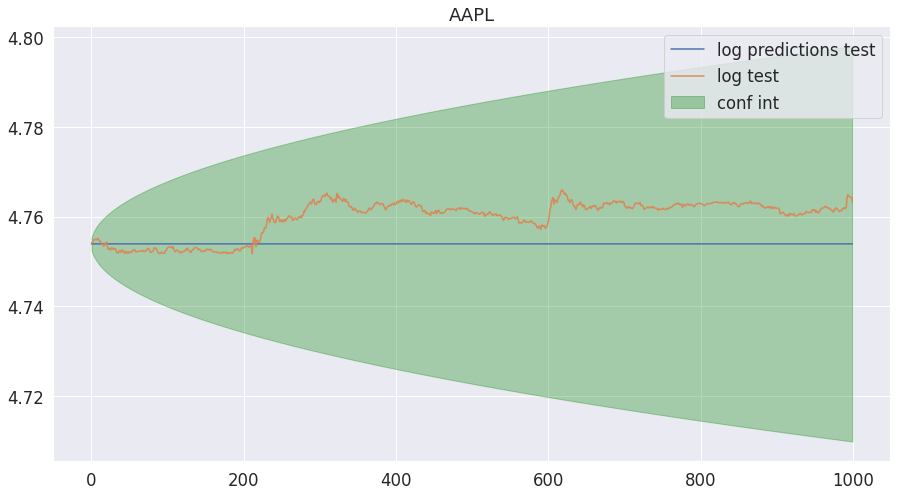

In [30]:
plt.figure(figsize=(15, 8))
plt.title('AAPL')
plt.plot(pred_mean, label='log predictions test')
plt.plot(np.log(apple_data_test), label='log test', alpha=0.9)
plt.fill_between(np.arange(0, 1000), pred_ci[:, 0], pred_ci[:, 1], 
                 color='green', alpha=0.3, label='conf int')
plt.legend()
plt.show()

In [0]:
apple_predictions = np.exp(pred_mean)
intervals = np.exp(pred_ci)

Посмотрим графики на тестовой выборке для исходных. В силу монотонности экспоненты они одинаковы, с точностью до масштаба.

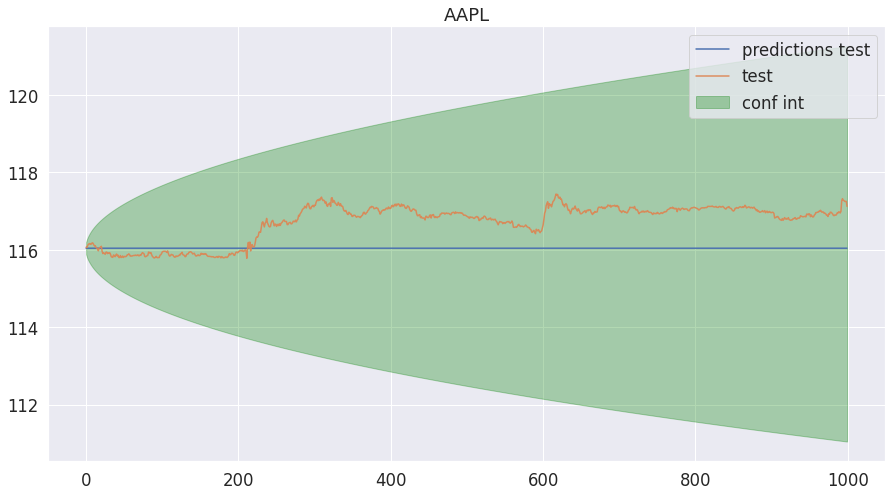

In [32]:
plt.figure(figsize=(15, 8))
plt.title('AAPL')
plt.plot(apple_predictions, label='predictions test')
plt.plot(apple_data_test, label='test', alpha=0.9)
plt.fill_between(np.arange(0, 1000), intervals[:, 0], intervals[:, 1], 
                 color='green', alpha=0.3, label='conf int')
plt.legend()
plt.show()

И на тренировочной, c **одношаговым** предсказанием.

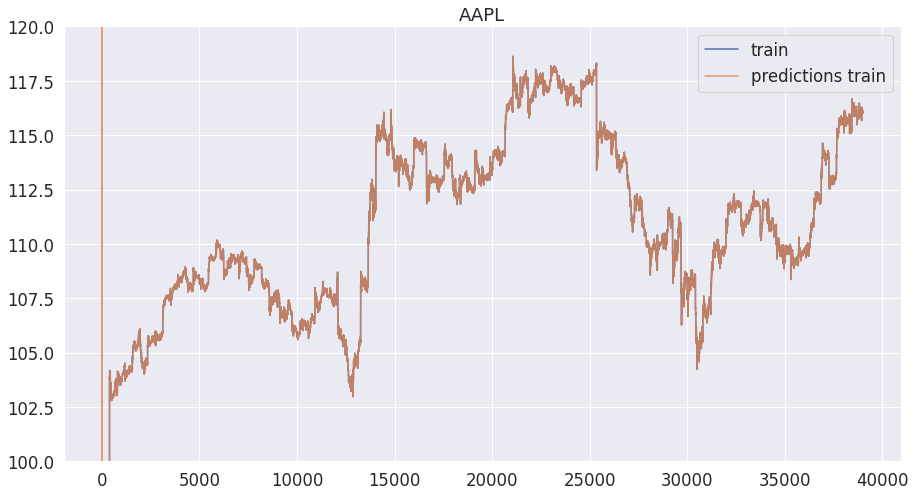

In [33]:
plt.figure(figsize=(15, 8))
plt.title('AAPL')
predictions = np.exp(model.predict(start=0, end=len(apple_data_train), 
                                   dynamic=False))
plt.plot(apple_data_train, label='train')
plt.plot(predictions, label='predictions train', alpha=0.8)
plt.ylim((100, 120))
plt.legend()
plt.show()

График предсказания на 1 шаг достаточно хорошо приближает тренировочный(они почти накладываются друг на друга). 

Теперь посчитаем метрики для модели ARIMA для двух датасетов. Будем использовать RMSE и MAPE.

In [0]:
metrics_test = pd.DataFrame(
    [
        [root_mean_squared_error(apple_predictions, 
                                 apple_data_test),
         mean_absolute_percentage_error(apple_data_test, 
                                        apple_predictions)],
        [root_mean_squared_error(electric_production_predictions, 
                                 elec_prod_preproc.test_data),
         mean_absolute_percentage_error(elec_prod_preproc.test_data, 
                                        electric_production_predictions)]
    ], 
    index = ['NASDAQ, AAPL',
             'Electric Production',
    ], 
    columns=['RMSE', 'MAPE']
)

In [35]:
metrics_test

,RMSE,MAPE
"NASDAQ, AAPL",0.824945,0.636258
Electric Production,9.411286,12.973127


Для периодического датасета, с ярко выраженной сезонностью результаты оказываются хуже, чем для апериодического датасета. Предсказание константой, из-за маленького изменения цены на акции Apple оказывается достаточно эффективным. Возможно, это связано с недостаточно хорошим подбором параметров с моей стороны. 
